In [3]:
import pandas as pd
import pickle
import os
import requests
import geopandas as gpd
import boto3
import io
from datetime import datetime
import pytz
from io import BytesIO
import json

In [4]:
def load_pkl(ruta):
    
    with open(ruta, 'rb') as archivo:
        datos = pickle.load(archivo)
    return datos

In [5]:
def leer_geojson(archivo_ruta):
    try:
        gdf = gpd.read_file(archivo_ruta)
        return gdf
    except Exception as e:
        print(f"Error al leer el archivo .geojson: {e}")
        return None

In [83]:
def guardar_geojson(geodf, filepath):
    try:
        # Guardar el GeoDataFrame como archivo .geojson
        geodf.to_file(filepath, driver="GeoJSON")
        print(f"Archivo guardado exitosamente en {filepath}")
    except Exception as e:
        print(f"Error al guardar el archivo: {e}")

## Datos de estaciones en linea- Precipitaciones de lluvia acumulada

In [6]:
# Diccionario global que almacenará la información recopilada
dicc_global = {
    'Estaciones': {}
}

In [7]:
#Traemos id activas
ruta_estaciones='../Data/input/Estaciones-Activas.csv'
estaciones_activas = pd.read_csv(ruta_estaciones)

In [8]:
rango_ids = estaciones_activas['ID'].tolist()

In [9]:
# URL de la API para obtener datos históricos de estaciones meteorológicas en un rango de fechas
url = 'https://satic.cali.gov.co:9090/api/estaciones/historico_data/rango_fecha'

# Lista de variables de tiempo para las que se solicitarán datos
rango_variables = ['24h', '7d', '10d', '15d', '30d', '60d', '90d']

# Estructura del diccionario para almacenar la información
dicc_estructura = {
        'id': [],
        '24h': [],
        '7d': [],
        '10d': [],
        '15d': [],
        '30d': [],
        '60d': [],
        '90d': []
    } 

In [10]:
# Iterar sobre los IDs de estaciones
for rango_id in rango_ids:
    # Iterar sobre los diferentes rangos de tiempo   
    for rango in rango_variables:
        # Configurar el cuerpo de la solicitud a la API
        body = {
            "id": rango_id,
            "rango": rango,
            "rangoFechaDisct": False
        }
        # Realizar la solicitud POST a la API con el cuerpo especificado
        resp = requests.post(url, json=body)
        # Obtener la respuesta en formato JSON
        info = resp.json()
        # Inicializar la suma acumulada de los registros de precipitación
        sum = 0
        # Verificar si la respuesta contiene información y tiene al menos un elemento
        if len(info) > 0:
            # Obtener la lista de datos de precipitación (P) del primer elemento de la respuesta
            p_list = info[0].get('P',[])
            # Iterar sobre los registros de precipitación y acumular los valores
            for registro in p_list:
                sum = sum + float(registro.get('acumulado'))
        # Agregar la suma acumulada al diccionario de estructura para el rango de tiempo actual
        dicc_estructura[rango].append(sum)
    # Agregar el nombre del sensor (nom_sensor) al diccionario de estructura
    dicc_estructura['id'].append(rango_id)

In [11]:
#Convierte la estructura del diccionario a un dataframe
df = pd.DataFrame(dicc_estructura)

In [12]:
df.head()

,id,24h,7d,10d,15d,30d,60d,90d
0,1,0.0,0.2,0.2,22.6,68.4,303.0,363.2
1,4,0.0,0.4,7.8,147.2,214.6,351.0,396.8
2,9,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,11,0.0,6.2,32.8,53.6,69.4,130.4,247.6
4,12,0.0,5.3,5.5,10.9,22.2,56.0,100.3


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23 entries, 0 to 22
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      23 non-null     int64  
 1   24h     23 non-null     float64
 2   7d      23 non-null     float64
 3   10d     23 non-null     float64
 4   15d     23 non-null     float64
 5   30d     23 non-null     float64
 6   60d     23 non-null     float64
 7   90d     23 non-null     float64
dtypes: float64(7), int64(1)
memory usage: 1.6 KB


In [66]:
ruta_cuadricula_mapa='../Data/input/cuadricula_datos_completa.geojson'
cuadricula = leer_geojson(ruta_cuadricula_mapa)

In [67]:
cuadricula=cuadricula.rename(columns={'ID_SATIC': 'id',
                                      'Categ_Ries': 'zonificacion',
                                      'CAT': 'Nomenclatura_del_Suelo',
                                      'Categ_CO_2': 'tipo_geologia'
                                      })

In [68]:
# Realiza un fusion con los datos del dataframe y la cuadricula
cuadricula = cuadricula.merge(df, on='id', how='left')

In [69]:
df_nuevos_datos=cuadricula.copy()

In [70]:
df_nuevos_datos = df_nuevos_datos.fillna(0)

In [71]:
df_nuevos_datos.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 3454 entries, 0 to 3453
Data columns (total 22 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   OBJECTID_1              3454 non-null   int32   
 1   COD_COB25_              3454 non-null   object  
 2   NOM_COB25               3454 non-null   object  
 3   SIM_COB25               3454 non-null   object  
 4   GEOLOGIA_1              3454 non-null   object  
 5   GEOLOGIA_2              3454 non-null   object  
 6   ELEVACION               3454 non-null   float64 
 7   PENDIENT                3454 non-null   float64 
 8   Categ_1                 3454 non-null   object  
 9   zonificacion            3454 non-null   int32   
 10  tipo_geologia           3454 non-null   int32   
 11  Nomenclatura_del_Suelo  3454 non-null   int32   
 12  NOMBRE_SIM              3454 non-null   object  
 13  id                      3454 non-null   int32   
 14  geometry        

In [72]:
columnas_resp=['NOM_COB25', 'GEOLOGIA_1','GEOLOGIA_2', 'ELEVACION', 'PENDIENT', 'Categ_1', 'zonificacion',
       'tipo_geologia', 'Nomenclatura_del_Suelo', 'NOMBRE_SIM', 'id','24h', '7d', '10d','15d', '30d', '60d', '90d', 'geometry' ]
df_nuevos_datos=df_nuevos_datos[columnas_resp]

In [73]:
df_nuevos_datos.head(3)

,NOM_COB25,GEOLOGIA_1,GEOLOGIA_2,ELEVACION,PENDIENT,Categ_1,zonificacion,tipo_geologia,Nomenclatura_del_Suelo,NOMBRE_SIM,id,24h,7d,10d,15d,30d,60d,90d,geometry
0,Bosque mixto denso alto de tierra firme,Kv,Formacion Volcanica,1984.197632,26.739103,Amenaza media,3,5,20,LA_TERESITA,23,0.0,0.3,3.6,48.7,289.8,445.0,523.0,"POLYGON ((-76.67031 3.45152, -76.67136 3.45152..."
1,Bosque mixto denso alto de tierra firme,Kv,Formacion Volcanica,2033.651123,6.319678,Amenaza media,3,5,20,LA_TERESITA,23,0.0,0.3,3.6,48.7,289.8,445.0,523.0,"POLYGON ((-76.67281 3.45402, -76.67281 3.45259..."
2,Bosque mixto denso alto de tierra firme,Kv,Formacion Volcanica,2095.797607,29.865055,Amenaza media,3,5,20,LA_TERESITA,23,0.0,0.3,3.6,48.7,289.8,445.0,523.0,"POLYGON ((-76.67281 3.45652, -76.67281 3.45402..."


In [74]:
columnas_modelo= ['ELEVACION','PENDIENT','zonificacion','Nomenclatura_del_Suelo','tipo_geologia','24h','7d','15d','30d','60d','90d']

In [ ]:
import warnings

# Apagar los warnings
warnings.filterwarnings('ignore')
ruta_model_deploy='../Models/output/production-model.pkl'
modelo=load_pkl(ruta_model_deploy)

In [76]:
def predecir_probabilidades(df_nuevos_datos, modelo, columnas):
    classifier=modelo["model"]
    calibrator=modelo["calibrator"]
    df_predict=df_nuevos_datos[columnas]
    # Predecir probabilidades
    y_pred_proba = classifier.predict_proba(df_predict)[:, 1]
    # Calibrar porbabildiades
    y_pred_calibrated = calibrator.predict(y_pred_proba)
    # Predecir probabilidades

    # Extraer las probabilidades para la clase positiva
    df_nuevos_datos['Probabilidad'] = y_pred_calibrated
    return df_nuevos_datos

In [77]:
probabilidades_nuevos_datos=predecir_probabilidades(df_nuevos_datos,modelo,columnas_modelo)

In [78]:
pd.options.display.max_columns = None

In [79]:
probabilidades_nuevos_datos.head(4)

,NOM_COB25,GEOLOGIA_1,GEOLOGIA_2,ELEVACION,PENDIENT,Categ_1,zonificacion,tipo_geologia,Nomenclatura_del_Suelo,NOMBRE_SIM,id,24h,7d,10d,15d,30d,60d,90d,geometry,Probabilidad
0,Bosque mixto denso alto de tierra firme,Kv,Formacion Volcanica,1984.197632,26.739103,Amenaza media,3,5,20,LA_TERESITA,23,0.0,0.3,3.6,48.7,289.8,445.0,523.0,"POLYGON ((-76.67031 3.45152, -76.67136 3.45152...",0.069844
1,Bosque mixto denso alto de tierra firme,Kv,Formacion Volcanica,2033.651123,6.319678,Amenaza media,3,5,20,LA_TERESITA,23,0.0,0.3,3.6,48.7,289.8,445.0,523.0,"POLYGON ((-76.67281 3.45402, -76.67281 3.45259...",0.045477
2,Bosque mixto denso alto de tierra firme,Kv,Formacion Volcanica,2095.797607,29.865055,Amenaza media,3,5,20,LA_TERESITA,23,0.0,0.3,3.6,48.7,289.8,445.0,523.0,"POLYGON ((-76.67281 3.45652, -76.67281 3.45402...",0.085116
3,Bosque mixto denso alto de tierra firme,Kv,Formacion Volcanica,2131.399902,67.399857,Amenaza media,3,5,20,LA_TERESITA,23,0.0,0.3,3.6,48.7,289.8,445.0,523.0,"POLYGON ((-76.67281 3.45902, -76.67281 3.45652...",0.822138


In [80]:
probabilidades_nuevos_datos=probabilidades_nuevos_datos.rename(columns={'NOM_COB25': 'Cobertura_Suelo',
                      'GEOLOGIA_1': 'Abreviacion_Unidad_Geologica_Suelo',
                      'GEOLOGIA_2': 'Unidad_Geologica_Suelo',
                      'PENDIENT': 'PENDIENTE',
                      'Categ_1': 'Clasificacion_Riesgo',
                      'Categ_Ries': 'Categorizacion_riesgo',
                      'Categ_CO_2': 'Categorizacion_cobertura_suelo',
                      'NOMBRE_SIM': 'Nombre_Estacion',
                      'CAT': 'Categorizacion_geologia'})

In [81]:
probabilidades_nuevos_datos.head(2)

,Cobertura_Suelo,Abreviacion_Unidad_Geologica_Suelo,Unidad_Geologica_Suelo,ELEVACION,PENDIENTE,Clasificacion_Riesgo,zonificacion,tipo_geologia,Nomenclatura_del_Suelo,Nombre_Estacion,id,24h,7d,10d,15d,30d,60d,90d,geometry,Probabilidad
0,Bosque mixto denso alto de tierra firme,Kv,Formacion Volcanica,1984.197632,26.739103,Amenaza media,3,5,20,LA_TERESITA,23,0.0,0.3,3.6,48.7,289.8,445.0,523.0,"POLYGON ((-76.67031 3.45152, -76.67136 3.45152...",0.069844
1,Bosque mixto denso alto de tierra firme,Kv,Formacion Volcanica,2033.651123,6.319678,Amenaza media,3,5,20,LA_TERESITA,23,0.0,0.3,3.6,48.7,289.8,445.0,523.0,"POLYGON ((-76.67281 3.45402, -76.67281 3.45259...",0.045477


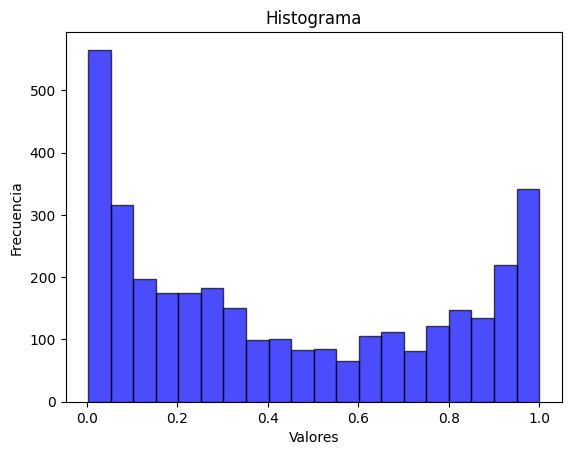

In [ ]:
# Distribucion de probabilidades:
import matplotlib.pyplot as plt
plt.hist(probabilidades_nuevos_datos['Probabilidad'], bins=20, color='blue', edgecolor='black', alpha=0.7)
plt.title("Histograma")
plt.xlabel("Valores")
plt.ylabel("Frecuencia")
plt.show()

In [84]:
ruta_new_data='../Data/output/new_Data_snap_shot.geojson'
ruta_infered_data='../Data/output/new_estimated_data.geojson'

In [85]:
guardar_geojson(df_nuevos_datos,ruta_new_data)
guardar_geojson(probabilidades_nuevos_datos,ruta_infered_data)

Archivo guardado exitosamente en ../Data/output/new_Data_snap_shot.geojson
Archivo guardado exitosamente en ../Data/output/new_estimated_data.geojson
